In [45]:
from datetime import datetime
import pandas as pd
from geopy.distance import distance
import numpy as np
import random

import pymongo
from pymongo import MongoClient



from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from sklearn.model_selection import cross_validate

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


import pymongo
from pymongo import MongoClient

import matplotlib.pyplot as plt

plt.style.use("ggplot")

%matplotlib inline

In [46]:
client = MongoClient('localhost', 27017)

db = client['avl_pipeline_test']

trip_coll = db['clean_trips']
chnk_coll = db['chunk_info']

In [13]:
all_trips = trip_coll.distinct('trip_id_iso')

In [14]:
trip_coll.find_one()

{'_id': ObjectId('5ae4dcb33ad39e1721401dad'),
 'HEADING': '82.0',
 'LATITUDE': '37.78693',
 'LONGITUDE': '-122.4565',
 'PREDICTABLE': '1',
 'REPORT_TIME': '10/28/2016 00:27:57',
 'REV': '1526',
 'SPEED': '0.0',
 'TRAIN_ASSIGNMENT': '3305',
 'VEHICLE_TAG': '5419',
 'minutes_noon_sqr': 480249,
 'sched_time_diff_seconds': 123,
 'service_id': 1,
 'time_stamp': 1477639677.0,
 'trip_id': 7253717,
 'trip_id_iso': '7253717_2016-10-28_JRMFT',
 'trip_start': 1,
 'chunk_2': '1',
 'chunk_6': '1',
 'chunk_12': '1'}

In [15]:
trip_list = []

for trip in all_trips:
    
    start_search = {
            'trip_id_iso': trip,
            'trip_start': 1
        }
    
    end_search = {
            'trip_id_iso': trip,
            'trip_end': 1
        }
    
    trip_start = trip_coll.find_one(start_search)    
    trip_end = trip_coll.find_one(end_search)
    
    if trip_start and trip_end:
    
        start_ts = trip_start['time_stamp']
        end_ts = trip_end['time_stamp']

        trip_duration = end_ts - start_ts
        
        mfn = trip_start['minutes_noon_sqr']
        
        trip_list.append([mfn, trip_duration])

In [22]:
clean_trips = []
for row in trip_list:
    if row[1] < 4500:
        clean_trips.append(row)

In [23]:
numps = np.array(clean_trips)

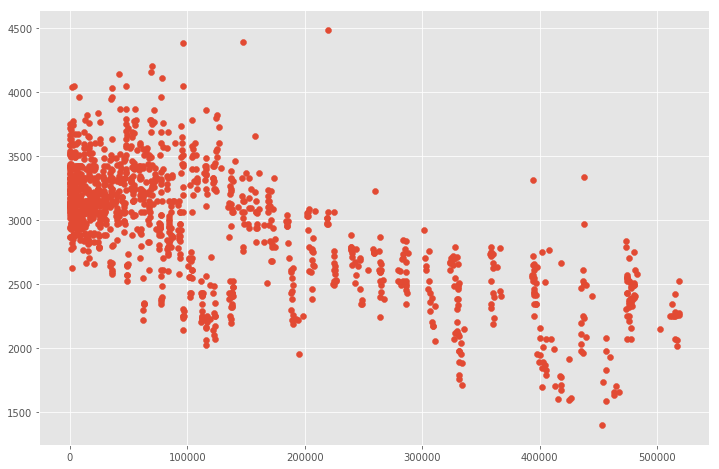

In [24]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(numps[:,0], numps[:,1]);

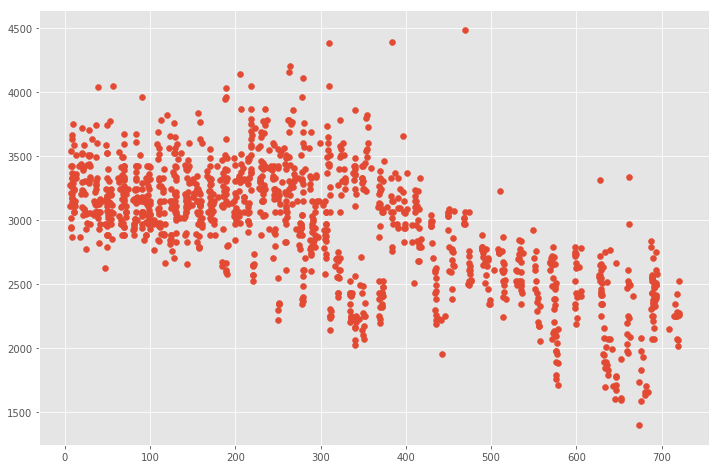

In [26]:
trip_list = []

for trip in all_trips:
    
    start_search = {
            'trip_id_iso': trip,
            'trip_start': 1
        }
    
    end_search = {
            'trip_id_iso': trip,
            'trip_end': 1
        }
    
    trip_start = trip_coll.find_one(start_search)    
    trip_end = trip_coll.find_one(end_search)
    
    if trip_start and trip_end:
    
        start_ts = trip_start['time_stamp']
        end_ts = trip_end['time_stamp']

        trip_duration = end_ts - start_ts
        
        if trip_duration > 4500:
            continue

        min_dt = datetime.fromtimestamp(start_ts)
        
        mfn = abs(((min_dt.hour * 60) + min_dt.minute) - 720)
        
        trip_list.append([mfn, trip_duration])
        
numps = np.array(trip_list)

fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(numps[:,0], numps[:,1]);

In [28]:
scaler = StandardScaler()
X_norm = scaler.fit_transform(numps[:,0].reshape(-1,1))

scaler_y = StandardScaler()
y_norm = scaler_y.fit_transform(numps[:,1].reshape(-1,1))

# X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm)

# X_norm = X
# y_norm = y

X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm)

In [42]:
# fit with statsmodels
model1 = sm.OLS(y_train,X_train)
results = model1.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.425
Method:                 Least Squares   F-statistic:                     732.3
Date:                Fri, 04 May 2018   Prob (F-statistic):          4.14e-121
Time:                        12:34:30   Log-Likelihood:                -1125.3
No. Observations:                 989   AIC:                             2253.
Df Residuals:                     988   BIC:                             2258.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.6429      0.024    -27.060      0.000      -0.689      -0.596
==============================================================================
Omnibus:                       44.614   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               62.662
Skew:                           0.410   Prob(JB):                     2.47e-14
Kurtosis:                       3.922   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [43]:
sms_pred = results.predict(X_test)
sms_pred = sms_pred.reshape(-1,1)

In [44]:
r2_score(y_test, sms_pred)

0.4182011885160548

In [50]:
scaler_y.inverse_transform([(mean_squared_error(y_test, sms_pred)**.5)])

array([3322.93827846])

In [41]:
regr = RandomForestRegressor(n_estimators=50)

crossed = cross_validate(regr, X_norm, y_norm.flatten(), cv=20, 
                         scoring=['neg_mean_squared_error','r2'], return_train_score=False)

rmse_norm = (abs(crossed['test_neg_mean_squared_error'].mean()))**.5
r2 = crossed['test_neg_mean_squared_error'].mean()

print ("R-squared: ", r2)
print ('RMSE: ', scaler_y.inverse_transform([rmse_norm])[0])

R-squared:  -0.5618625205385755
RMSE:  3312.748683492248


In [40]:
ols = LinearRegression()

ols_crossed = cross_validate(ols, X_norm, y_norm, cv=20, 
                         scoring=['neg_mean_squared_error','r2'], return_train_score=False)

rmse_norm = (abs(ols_crossed['test_neg_mean_squared_error'].mean()))**.5
r2 = ols_crossed['test_neg_mean_squared_error'].mean()

print ("R-squared: ", r2)
print ('RMSE: ', scaler_y.inverse_transform([rmse_norm])[0])

R-squared:  -0.5808567001554623
RMSE:  3318.618929728479
